# Two-body problem: Analysis notebook

## Name: Males-Araujo Yorlan

### Module design

We present both the directory and source code structure of **Atramenta**, our package for simulating planet orbits around a black hole.

#### Directory structure
```sh
atramenta/
├── atramenta/
│   ├── __init__.py
│   ├── orbits.py          # Source code
│   └── test_orbits.py     # Unit tests
│   
├── README.md              # Brief usage instructions
├── analysis.ipynb         # Comparing and analyzing results
│  
├── outputfolder/
│   ├── *.h5               # Orbital history
│   └── *.gif              # Animations
│
└── setup.py          
```

#### Code structure (`orbits.py`)

The code is organized into three main classes: `OrbitBirther` (initializer), `CelestialSeer` (integrator), and `ChronoPainter` (animator). The first two are responsible for simulating orbits, and the last one is for visualizing them. Not all methods or arguments are shown, only the most relevant ones. 

```sh
orbits.py
├── OrbitBirther
│   ├── __init__(M, a, e)         
│   ├── initial_conditions()      # Calculate initial conditions              
│   └── schwarzschild_radius()    # and Schwarzschild radius
│
├── CelestialSeer(OrbitBirther)
│   ├── __init__(M, a, e)
│   │
│   ├── Public methods
│   │   ├── integrate(N, method, relativistic)       # Main integration method 
│   │   └── measure_convergence()                    # Convergence across step sizes
│   │
│   └── Private methods
│       ├── _classical_slope()
│       ├── _relativistic_slope()
│       ├── _trapezoidal()
│       ├── _rk3()
│       ├── _save_solutions()
│       └── _schwarzschild_restriction()      # No values smaller than this
│
├── ChronoPainter
│   │   └── __init__(orbits, labels, colors)
│   │   
│   ├── Public methods
│   │   ├── paint()                  # GIF generation
│   │   └── show_evolution()
│   │
│   └── Private methods
│       ├── _read(orbital_history)
│       ├── _save_sketch()           # Saves frames
│       └── _burn_sketches()         # Deletes frames once GIF is done
│
├── Utility functions
│   ├── plot_orbit()             
│   └── parse_args()       # Command line arguments
│
└── Main execution
```

### Relativistic vs. classical mechanics

##### (i) Use your module/script to run and show two simulations: one relativistic and one classical for this set of initial conditions. It may be helpful to compare the orbital history in a single plot.

| Parameter | Description                                       | Units      |
|-----------|---------------------------------------------------|------------|
| $e$       | Eccentricity of the orbit                         | $0$        |
| $M$       | Mass of the central black hole                    | $5\times 10^6\,\rm M_\odot$ |
| $a$       | Semi-major axis of the orbit                      | $1\,\rm AU$|
| $N$       | Number of orbital periods to simulate             | $2$        |
| Method    | Numerical method for ODE integration              | RK3        |

In [1]:
# Module import
from orbits import CelestialSeer, ChronoPainter

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set parameters
M = 5e6 # Solar masses
a = 1.0 # AU
e = 0.0
N = 2.0

In [3]:
# Instantiate the integrator
orbital_sys = CelestialSeer(M, a, e)

In [4]:
# Classical case
t_class, S_class, file_class = orbital_sys.integrate(
    relativistic = False, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True) 

# Relativistic case
t_relat, S_relat, file_relat = orbital_sys.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

Simulation results saved to outputfolder/M5.0e+06-a1.0-e0.000-class-RK3.h5.
Simulation results saved to outputfolder/M5.0e+06-a1.0-e0.000-relat-RK3.h5.


In [5]:
# Create instance of the painter
painter = ChronoPainter(
    orbits = (file_class, file_relat),
    labels = ('Classical', 'Relativistic'),
    colors = ('khaki', 'magenta')
    )

In [6]:
# # Animate
# painter.paint(
#     gif_name = "rel-vs-class.gif",
#     frames = 75,
#     duration = 0.5,
#     dpi = 100
# )

In [7]:
# Show it
# painter.show_evolution("rel-vs-class.gif")

to ellaborate on: no precession

##### (j) Use the orbital history of both simulations to design a method that quantifies their differences and evaluates the importance of using the relativistic approach for massive objects. Do we need to worry about the relativistic corrections if we replace the black hole with our Sun?


---
**Quantitative analysis**

We will see how much both the positions and velocities differ *on average* over the entire time evolution.

In [8]:
def mean_euclidean(s1, s2):
    """
    Calculate the mean Euclidean distance between two sets of positions.
    """
    # Extract positions and velocities
    pos1 = s1[0:2, :]
    pos2 = s2[0:2, :]
    vel1 = s1[2:4, :]
    vel2 = s2[2:4, :]

    # Magnitude of velocities
    v1_mag = np.linalg.norm(vel1, axis = 0) 
    v2_mag = np.linalg.norm(vel2, axis = 0)

    # Calculate the mean distance and velocity over time
    mean_distance = np.mean(np.linalg.norm(pos1 - pos2, axis = 0)) # AU
    mean_velocity = np.mean(np.abs(v1_mag - v2_mag))               # AU/yr

    return mean_distance, mean_velocity

In [9]:
# Calculate the mean Euclidean distance
mean_distance, mean_velocity = mean_euclidean(S_class, S_relat)
print(f"Mean distance: {mean_distance:.4f} AU")
print(f"Mean velocity: {mean_velocity:.4f} AU/yr")

Mean distance: 1.2847 AU
Mean velocity: 2479.8900 AU/yr


they do differ by a lot

---

**Sun case**

The only change we have to do is set the mass to $1\,\rm M_\odot$ and the rest is the same.

In [10]:
# Sun
M_sun = 1 # Solar masses

# Create another instance
integrator2 = CelestialSeer(M_sun, a, e)

In [11]:
# Classical case
t_class2, S_class2, file_class_sun = integrator2.integrate(
    relativistic = False, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

# Relativistic case
t_relat2, S_relat2, file_relat_sun = integrator2.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

Simulation results saved to outputfolder/M1.0e+00-a1.0-e0.000-class-RK3.h5.
Simulation results saved to outputfolder/M1.0e+00-a1.0-e0.000-relat-RK3.h5.


In [12]:
# Create another instance
painter2 = ChronoPainter(
    orbits = (file_class_sun, file_relat_sun),
    labels = ('Classical', 'Relativistic'),
    colors = ('khaki', 'magenta')
    )

In [13]:
# # Animate
# painter2.paint(
#     gif_name = "rel-vs-class-sun.gif",
#     frames = 75,
#     duration = 0.5,
#     dpi = 100
# )

In [14]:
# Show it
# painter2.show_evolution("rel-vs-class-sun.gif")

short answer: no, we do not need to worry when the mass is that of the sun

### The role of eccentricity (3 points):

##### (k) Use your module/script to run and show three relativistic simulations for objects with different eccentricities, $e$, and assuming the same $M$, $a$, $N$ as above. It may be helpful to compare the orbital history for all values of $e$ in a single plot throughout time.

| Object           | Eccentricity ($e$) | Integration Method |
|------------------|--------------------|--------------------|
| Earth            | 0.01671            | Trapezoidal        |
| Pluto            | 0.25               | Trapezoidal        |
| 7092 Cadmus      | 0.70               | Trapezoidal        |

In [15]:
# Define eccentricities
e_earth  = 0.01671
e_pluto  = 0.25
e_cadmus = 0.70

In [16]:
# Create instances
earth_sys  = CelestialSeer(M, a, e_earth)
pluto_sys  = CelestialSeer(M, a, e_pluto)
cadmus_sys = CelestialSeer(M, a, e_cadmus)

# Integrate
t_earth, S_earth, file_earth = earth_sys.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

t_pluto, S_pluto, file_pluto = pluto_sys.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3',
    save_hdf5 = True)

t_cadmus, S_cadmus, file_cadmus = cadmus_sys.integrate(
    relativistic = True, 
    N = N, 
    method = 'RK3', 
    save_hdf5 = True)

Simulation results saved to outputfolder/M5.0e+06-a1.0-e0.017-relat-RK3.h5.
Simulation results saved to outputfolder/M5.0e+06-a1.0-e0.250-relat-RK3.h5.
Simulation results saved to outputfolder/M5.0e+06-a1.0-e0.700-relat-RK3.h5.


In [17]:
# Create instance
painter3 = ChronoPainter(
    orbits = (file_earth, file_pluto, file_cadmus),
    labels = ('Earth', 'Pluto', 'Cadmus'),
    colors = ('khaki', 'magenta', 'white')
    )

In [18]:
# # Animate
# painter3.paint(
#     gif_name = "diff_eccentricities.gif",
#     frames = 75,
#     duration = 0.5,
#     dpi = 100
# )

In [23]:
# Show it
# painter3.show_evolution("diff_eccentricities.gif")

##### (l) Describe the differences in the orbits of the above objects. What happens to objects with high eccentricities?

to do

### Numerical convergence (3 points):

##### (m) Use your script to generate additional simulations with the same initial conditions as before, but only for $e=0.01671$ (Earth's eccentricity) with RK3, the Trapezoidal method and the higher-order SciPy integrator. Compare the orbital history for all methods in a single plot throughout time.

We are going to use slightly different orbital periods.

In [24]:
# Integrate
t_earth_tpz, S_earth_tpz, file_tpz = earth_sys.integrate(
    relativistic = True, 
    N = 2.01, 
    method = 'TPZ', 
    save_hdf5 = True)

t_earth_spy, S_earth_spy, file_spy = earth_sys.integrate(
    relativistic = True, 
    N = 2.02, 
    method = 'SPY', 
    save_hdf5 = True)

Simulation results saved to outputfolder/M5.0e+06-a1.0-e0.017-relat-TPZ.h5.
Simulation results saved to outputfolder/M5.0e+06-a1.0-e0.017-relat-SPY.h5.


In [25]:
# Create instance
painter4 = ChronoPainter(
    orbits = (file_earth, file_tpz, file_spy),
    labels = ('RK3', 'TPZ', 'SPY'),
    colors = ('khaki', 'magenta', 'white')
    )

In [26]:
# # Animate
# painter4.paint(
#     gif_name = "diff_methods.gif",
#     frames = 75,
#     duration = 0.5,
#     dpi = 100
# )

In [29]:
# Show it
# painter4.show_evolution("diff_methods.gif")

no diff for $N=2$

##### (n) Measure convergence of the simulations with RK3 and Trapezoidal method for $e=0.01671$ by integrating at a number of different time steps. To analyse convergence, you need to define some measure for the error with respect to the higher order method, and then plot it against different time steps for both methods. Thus, you may add additional functions for this to your code in **orbits.py**. 

In [38]:
# Module import
from orbits import CelestialSeer, ChronoPainter

import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Create instance
orbital_sys = CelestialSeer(
    M = 5e6,
    a = 1.0,
    e = 0.0167
    )

In [ ]:
errors_rk3 = orbital_sys.measure_convergence(
    N = 2.0,
    method = 'RK3',
    relativistic = True,
    sim_steps = (500, 400, 300, 200, 100)
)
errors_tpz = orbital_sys.measure_convergence(
    N = 2.0,
    method = 'TPZ',
    relativistic = True,
    sim_steps = (500, 400, 300, 200, 100)
)

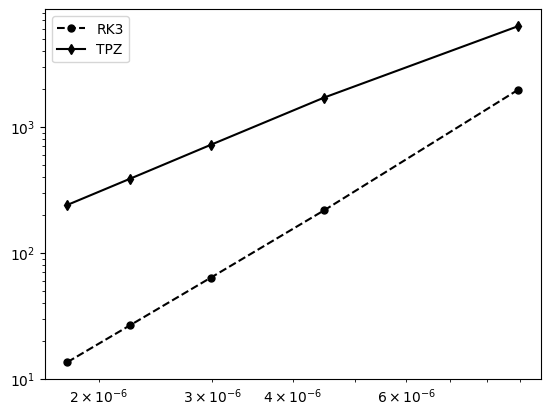

In [42]:
plt.plot(errors_rk3[0], errors_rk3[1], 
         ls = '--', label = 'RK3', c = "k",
         marker = 'o', markersize = 5)
plt.plot(errors_tpz[0], errors_tpz[1], 
         ls = '-', label = 'TPZ', c = "k",
         marker = 'd', markersize = 5)
plt.loglog()
plt.legend()
plt.show()

In [6]:
print(errors_rk3[2], errors_tpz[2])

3.092229775757989 2.0350487712871344


In [45]:
print(errors_rk3[0])

[1.788854381999832e-06, 2.23606797749979e-06, 2.9814239699997195e-06, 4.47213595499958e-06, 8.94427190999916e-06]
